### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


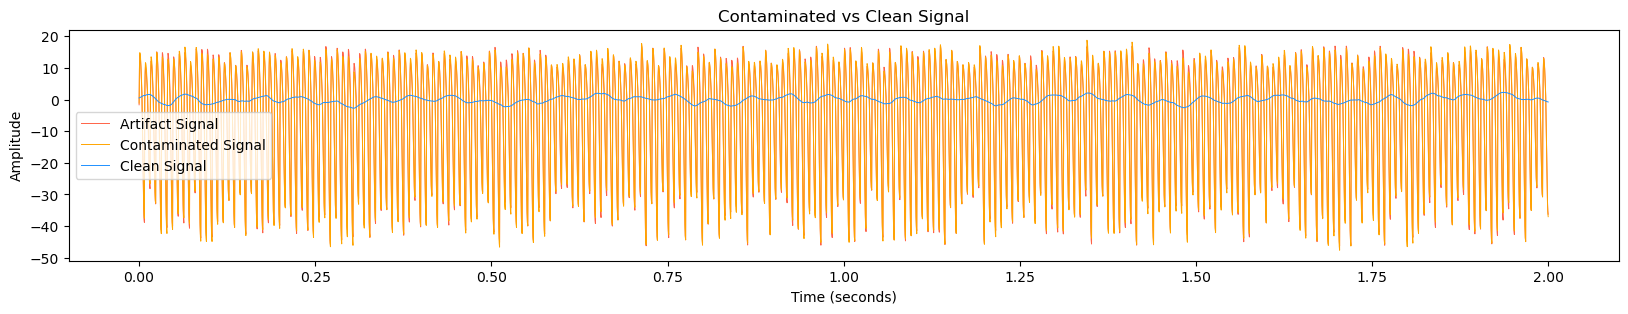

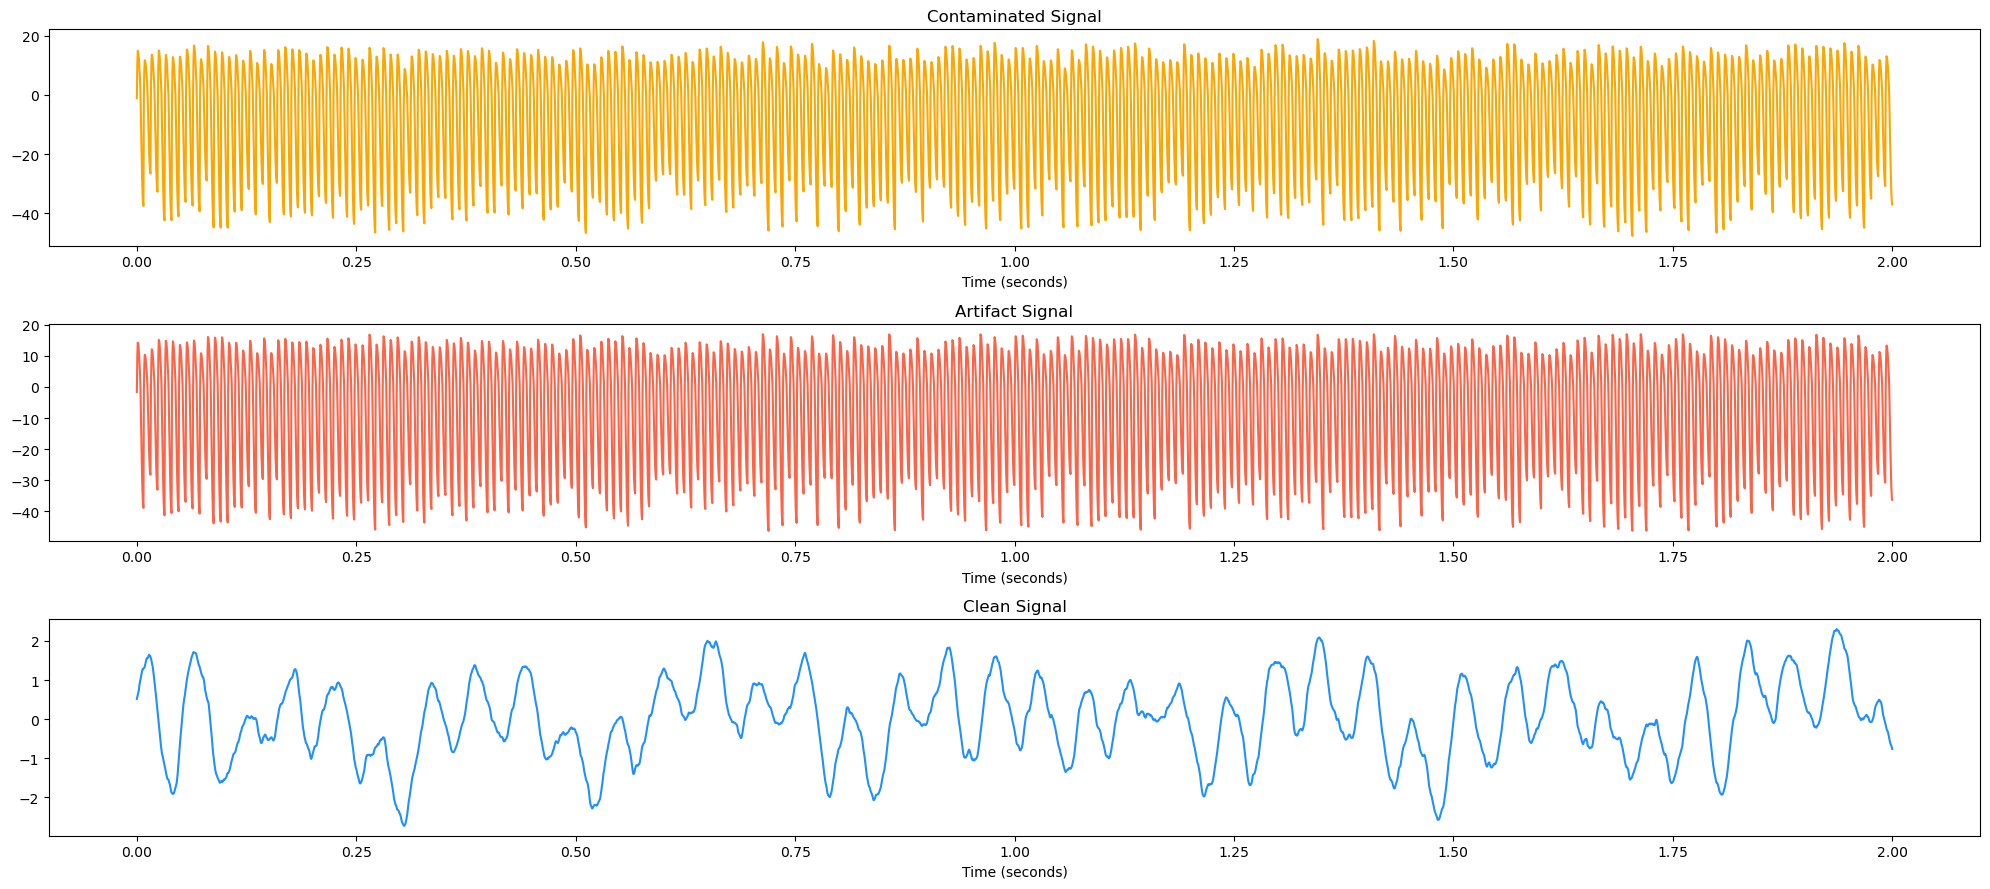

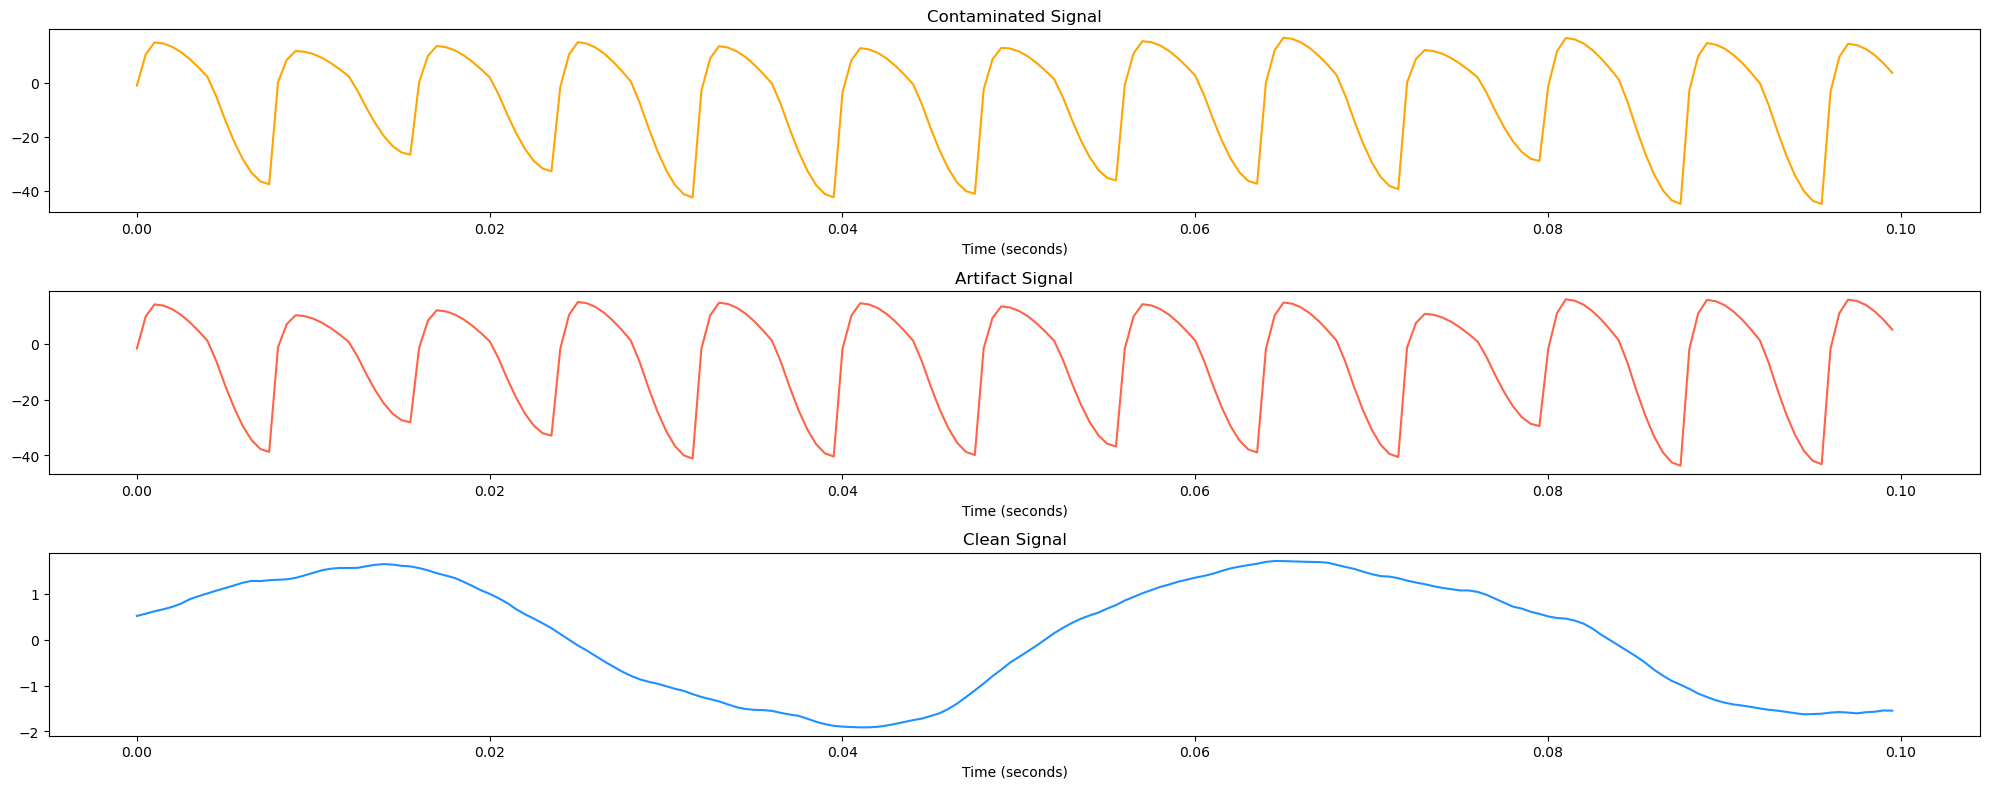

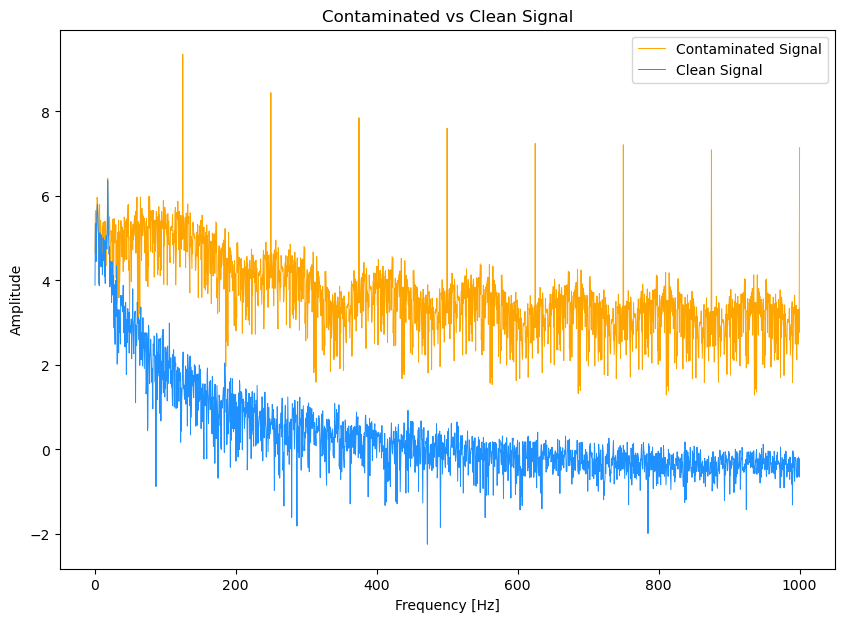

In [2]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)
-----------------------------


In [5]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        # output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)

        return out
    
class simpleLSTM1d(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.net = nn.Sequential(*[
            LSTM_Block(hidden_size, hidden_size, 1)
            for i in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.fc1(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.fc2(x).squeeze(-1) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [6]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_welch, y_welch):
        signal_loss = self.mse_loss(y_pred, y)
        welch_loss = self.mse_loss(y_pred_welch, y_welch)
        return self.alpha * signal_loss + (1 - self.alpha) * welch_loss

In [7]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 128  # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = simpleLSTM1d(input_size, hidden_size, output_size, num_layers).to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
alpha = 0.5
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()
fs = 2000

simpleLSTM1d(
  (dropout): Dropout(p=0.1, inplace=False)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (net): Sequential(
    (0): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
    (1): LSTM_Block(
      (lstm): LSTM(128, 128, batch_first=True)
      (gelu): GELU(approximate='none')
    )
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [8]:
# 모델 훈련
num_epochs = 200

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.shape
        y = y.view(batch_size, -1)
        y_pred = y_pred.view(batch_size, -1)

        # 텐서를 CPU로 옮기고 NumPy 배열로 변환
        y_cpu = y.detach().cpu().numpy()
        y_pred_cpu = y_pred.detach().cpu().numpy()

        
        # Welch 스펙트럼 계산
        y_welch_list = [welch(y_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]
        y_pred_welch_list = [welch(y_pred_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]

        # Welch 결과의 길이를 모델의 입력 형태와 맞추기
        # 여기에 적절한 패딩이나 크기 조정이 필요할 수 있습니다
        y_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_welch_list])
        y_pred_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_pred_welch_list])

        # NumPy 배열을 다시 텐서로 변환하여 손실 함수에 전달
        y_welch = torch.tensor(y_welch, dtype=torch.float32).to(device)
        y_pred_welch = torch.tensor(y_pred_welch, dtype=torch.float32).to(device)

        loss = criterion(y_pred, y, y_pred_welch, y_welch)
        y_val_mse = mse(y_pred, y)*alpha
        y_welch_mse = mse(y_pred_welch, y_welch)*(1-alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1)%1 == 0:
       print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():6f} | y_val_mse: {y_val_mse:6f} | y_welch_mse: {y_welch_mse}')

Epoch [1/200] | Loss: 0.002667 | y_val_mse: 0.002667 | y_welch_mse: 3.424317903885643e-12
Epoch [2/200] | Loss: 0.001463 | y_val_mse: 0.001463 | y_welch_mse: 3.3523084481956733e-12
Epoch [3/200] | Loss: 0.001443 | y_val_mse: 0.001443 | y_welch_mse: 3.4159010255802036e-12
Epoch [4/200] | Loss: 0.001438 | y_val_mse: 0.001438 | y_welch_mse: 3.4078354287786494e-12
Epoch [5/200] | Loss: 0.001427 | y_val_mse: 0.001427 | y_welch_mse: 3.3241905322139997e-12
Epoch [6/200] | Loss: 0.001416 | y_val_mse: 0.001416 | y_welch_mse: 3.3694611770856975e-12
Epoch [7/200] | Loss: 0.001354 | y_val_mse: 0.001354 | y_welch_mse: 3.4557265903012446e-12
Epoch [8/200] | Loss: 0.001128 | y_val_mse: 0.001128 | y_welch_mse: 2.9865001530821056e-12
Epoch [9/200] | Loss: 0.000897 | y_val_mse: 0.000897 | y_welch_mse: 2.027018310146733e-12
Epoch [10/200] | Loss: 0.000600 | y_val_mse: 0.000600 | y_welch_mse: 4.951674920788962e-13
Epoch [11/200] | Loss: 0.000524 | y_val_mse: 0.000524 | y_welch_mse: 4.90394400434746e-13
Ep

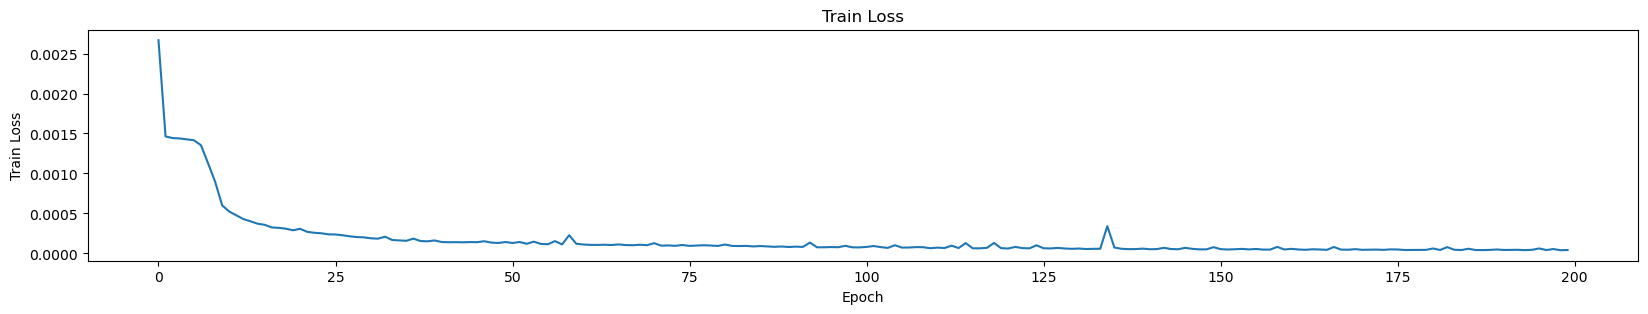

Minimal Train Loss: 4.007896131952293e-05 [198]



In [11]:
# Train Loss Plot
Train_Loss_Plot(loss_list)

In [12]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        # batch_size, seq_len = y.shape
        # y = y.view(batch_size, -1).cpu()
        # y_pred = y_pred.view(batch_size, -1).cpu()
        # print("y.shape:", y.shape)

        # _, y_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        # _, y_pred_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        # print("y_welch.shape:", y_welch.shape)

        # loss = criterion(y_pred, y, y_pred_welch, y_welch)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)
        # SACed_spectro = torch.cat((SACed_spectro, y_pred_welch.cpu()), 0)
        # Clean_spectro = torch.cat((Clean_spectro, y_welch.cpu()), 0)

# val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
# print(f'Test Loss: {val_loss.item()}')           

<Time Domain Error>
Mean Absolute Error: 0.11316167864806018
Mean Squared Error: 0.02267301456108564


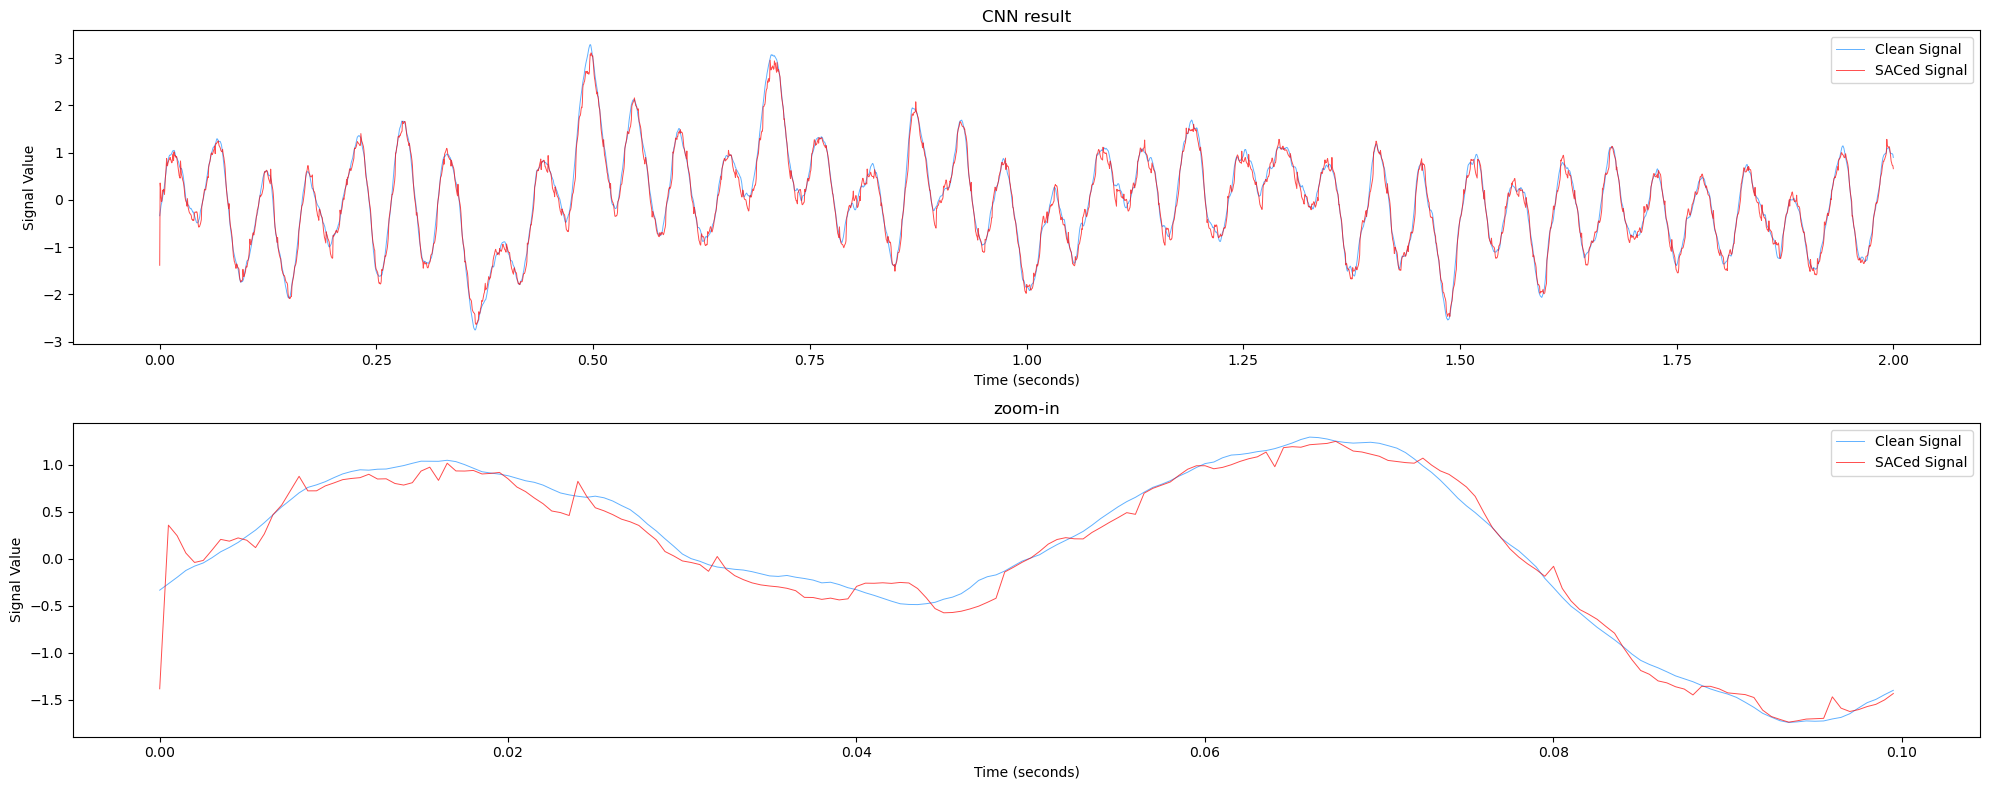

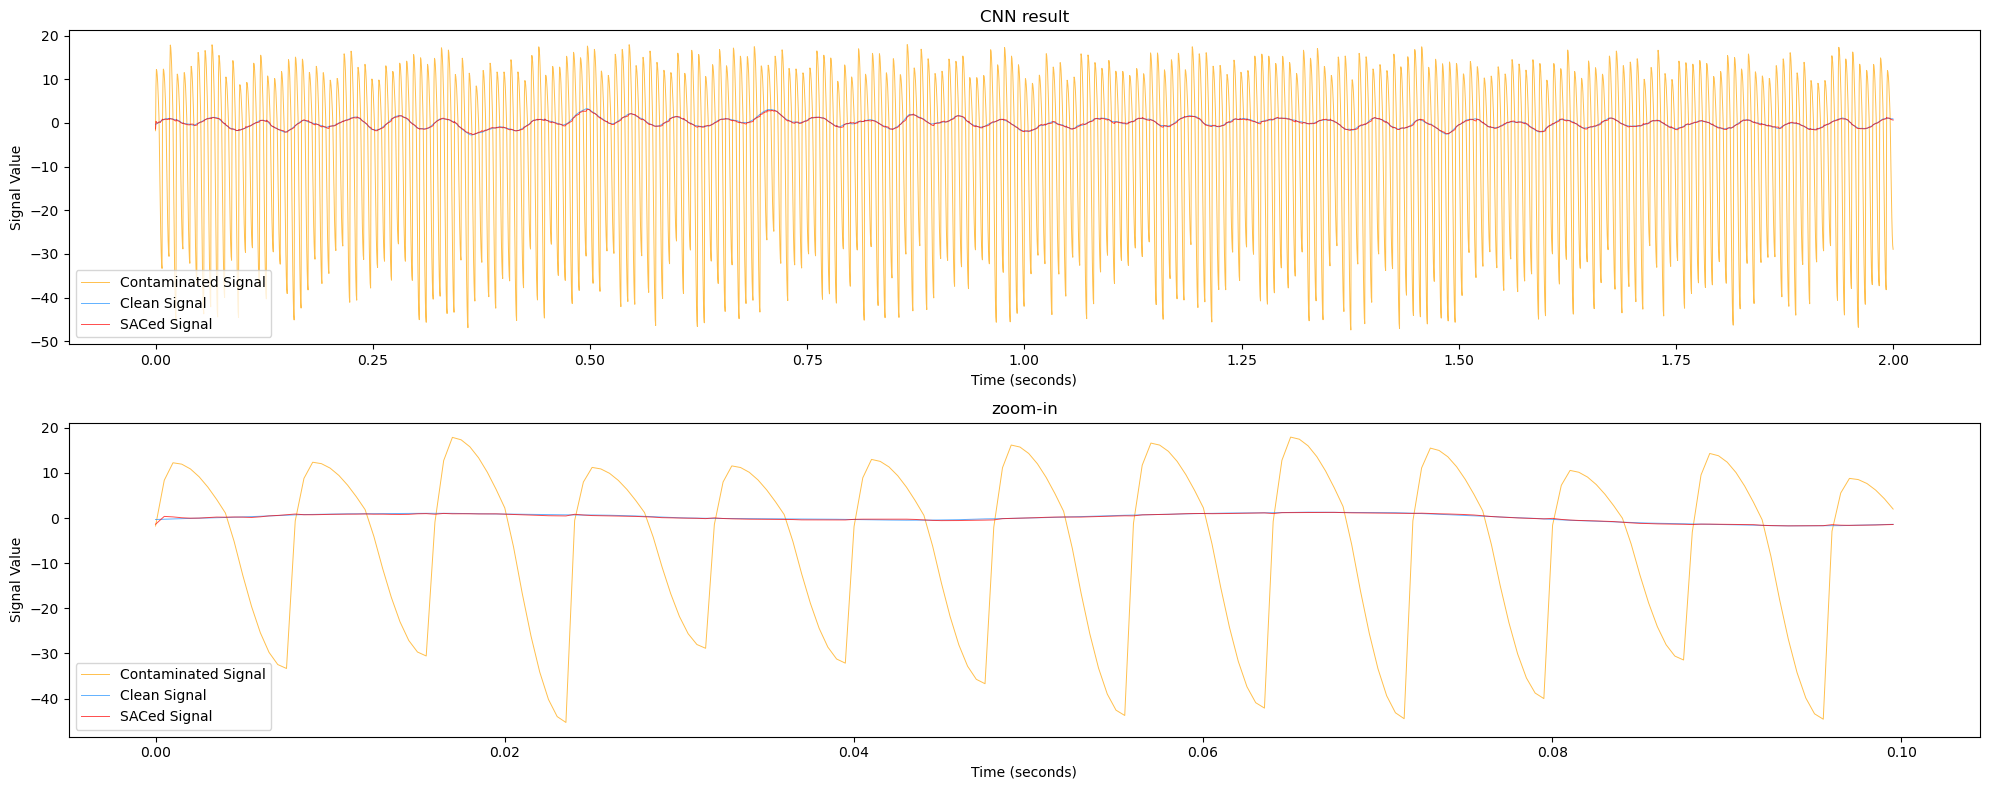

<Frequency Domain Error>
Mean Absolute Error: 0.982380257886658
Mean Squared Error: 1.5954741095779106


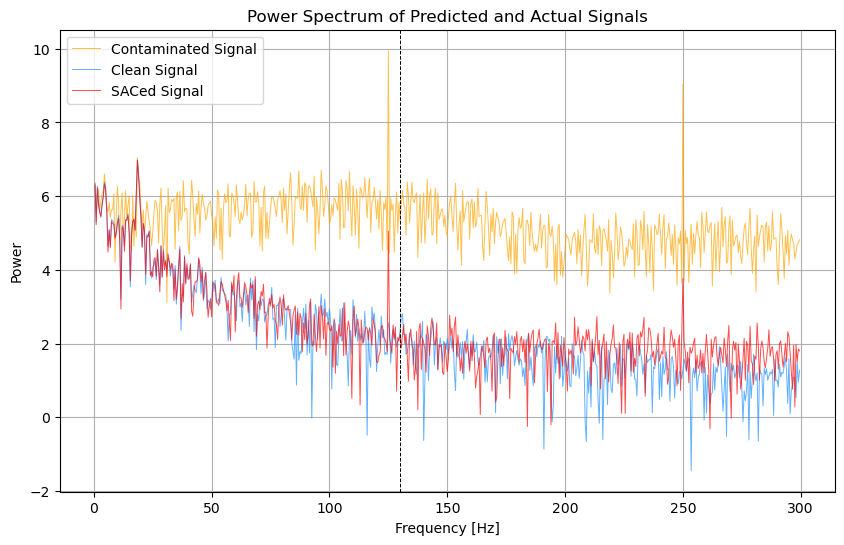

In [14]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

<Time Domain Error>
Mean Absolute Error: 0.006081415340304375
Mean Squared Error: 6.548168312292546e-05


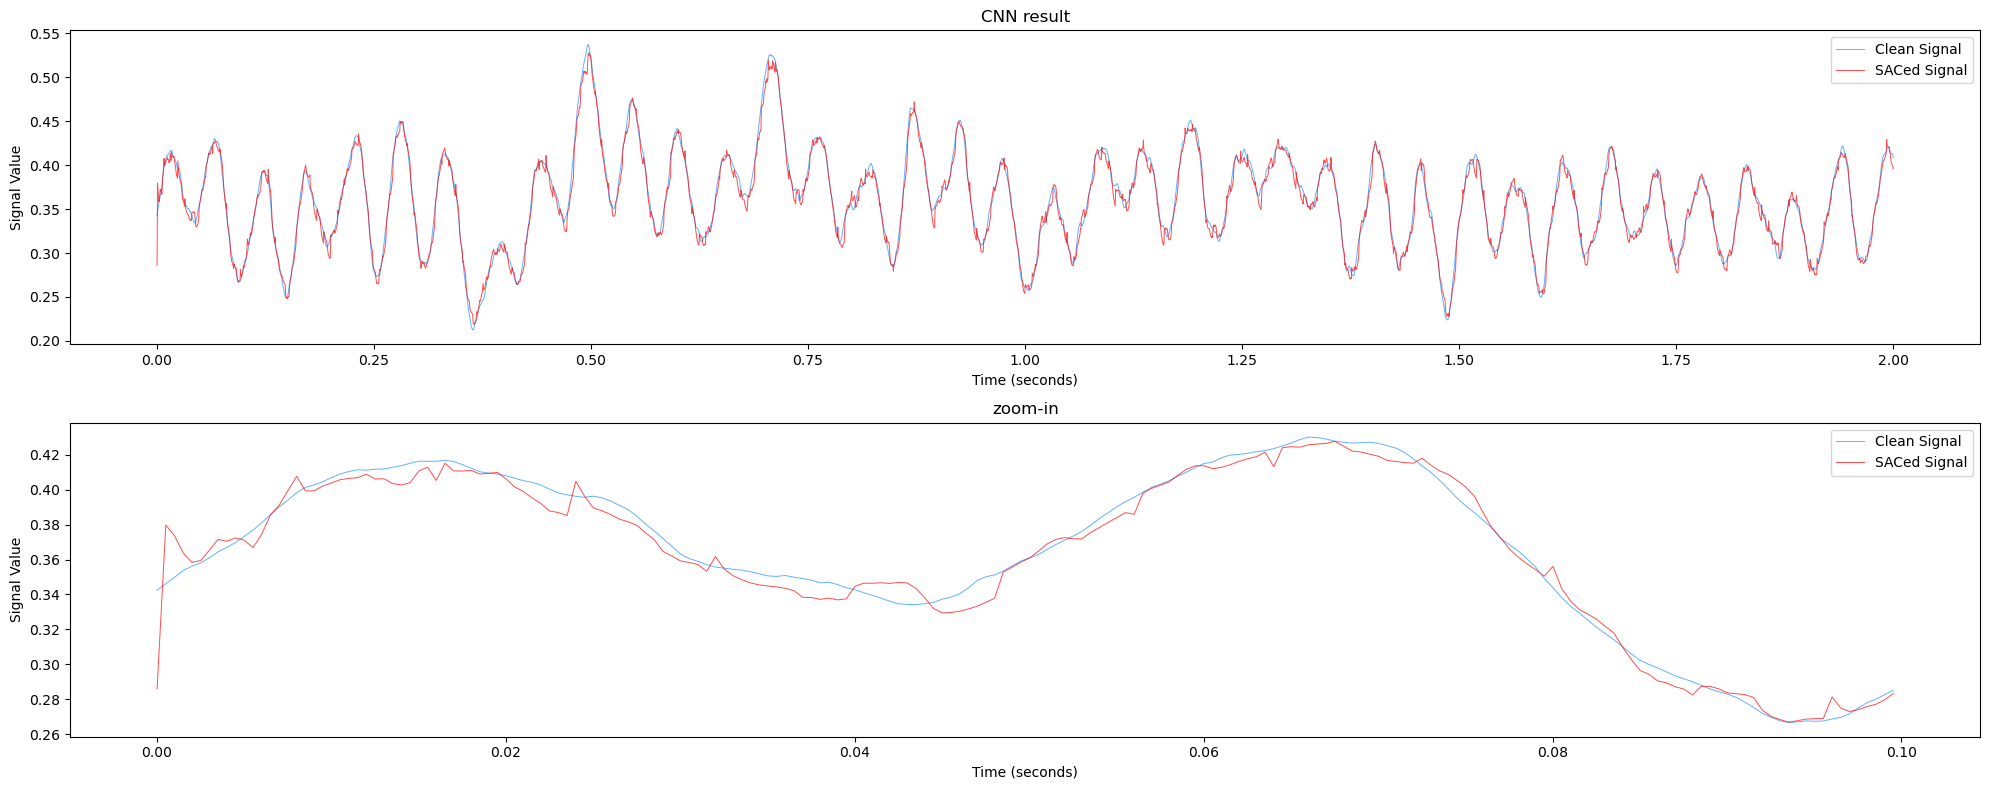

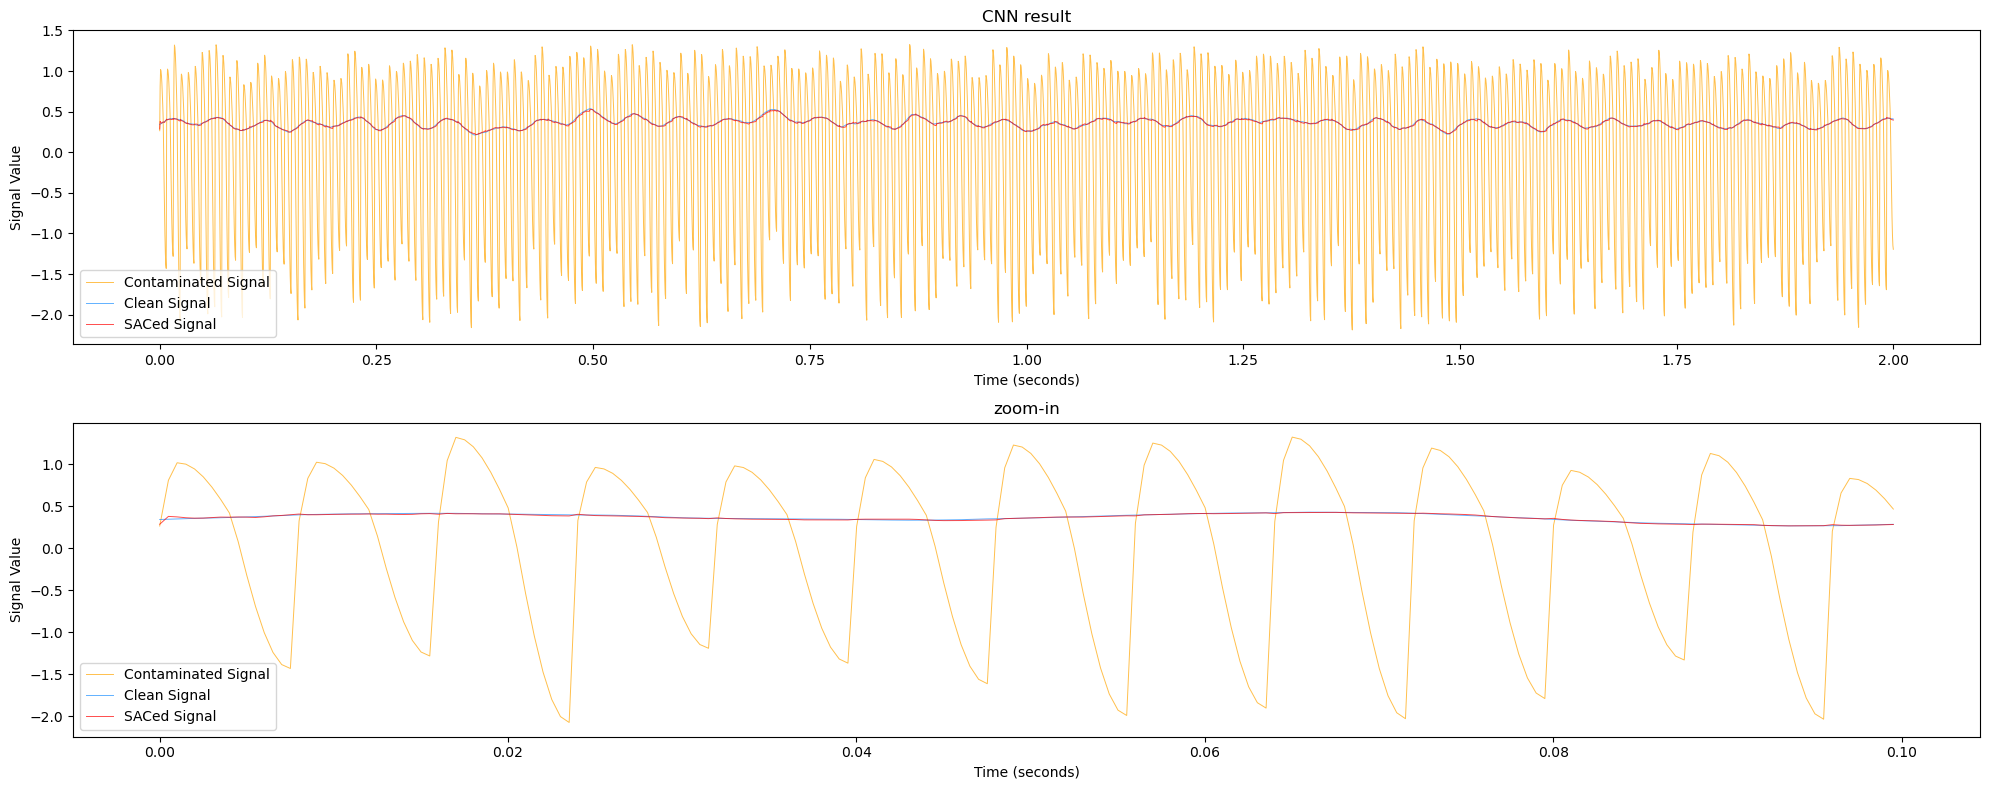

<Frequency Domain Error>
Mean Absolute Error: 0.9749482493527752
Mean Squared Error: 1.4844425605188472


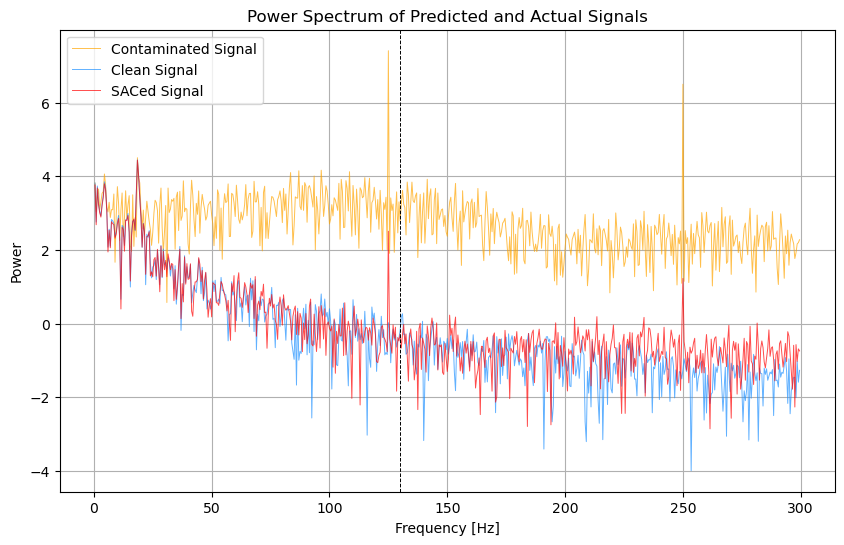

In [15]:
# 원래 scale
Result_Plot(Contaminated, SACed, Clean)